# ***Classification: User Visit Mode Prediction***

This notebook handles:
 1. Preparing data for visit mode prediction (classification)
 2. Training and evaluating classification models
 3. Handling class imbalance
 4. Saving the model pipeline

## **1. Data Preparation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# Load preprocessed data
print("Loading preprocessed data...")
try:
    merged_df = pd.read_csv('preprocessed_tourism_data.csv')
    # Convert date columns if needed
    if 'VisitDate' in merged_df.columns:
        merged_df['VisitDate'] = pd.to_datetime(merged_df['VisitDate'])
except FileNotFoundError:
    print("Error: preprocessed_tourism_data.csv not found. Please run main.ipynb first.")
    raise

Loading preprocessed data...


### **1.1 Identify Visit Mode Columns**

In [3]:
# Check available columns
print("Columns in dataset:")
print(merged_df.columns.tolist())

# Find all columns related to visit mode
visit_mode_cols = [col for col in merged_df.columns if 'VisitMode' in col]
print("\nVisit mode related columns:", visit_mode_cols)

Columns in dataset:
['AvgRating', 'TotalVisits', 'RatingStd', 'UniqueAttractions', 'VisitModeProp_Business', 'VisitModeProp_Couples', 'VisitModeProp_Family', 'VisitModeProp_Friends', 'VisitModeProp_Solo', 'VisitMode_y_Couples', 'VisitMode_y_Family', 'VisitMode_y_Friends', 'VisitMode_y_Solo', 'AttractionType_Ballets', 'AttractionType_Beaches', 'AttractionType_Caverns & Caves', 'AttractionType_Flea & Street Markets', 'AttractionType_Historic Sites', 'AttractionType_History Museums', 'AttractionType_National Parks', 'AttractionType_Nature & Wildlife Areas', 'AttractionType_Neighborhoods', 'AttractionType_Points Of Interest & Landmarks', 'AttractionType_Religious Sites', 'AttractionType_Spas', 'AttractionType_Speciality Museums', 'AttractionType_Volcanos', 'AttractionType_Water Parks', 'AttractionType_Waterfalls', 'ContinentId_2', 'ContinentId_3', 'ContinentId_4', 'ContinentId_5', 'Country_freq_encoded', 'VisitYear', 'VisitMonth', 'IsWeekend', 'Rating']

Visit mode related columns: ['Visit

### **1.2 Target Variable Preparation**

In [4]:
# Option 1: Use VisitMode from visit_data if available
if 'VisitMode' in merged_df.columns:
    target_col = 'VisitMode'
# Option 2: Reconstruct from one-hot encoded columns
elif any(col.startswith('VisitMode_y_') for col in merged_df.columns):
    visit_mode_cols = [col for col in merged_df.columns if col.startswith('VisitMode_y_')]
    target_col = 'VisitMode_reconstructed'
    merged_df[target_col] = merged_df[visit_mode_cols].idxmax(axis=1).str.replace('VisitMode_y_', '')
else:
    raise ValueError("No suitable visit mode target column found")

print("\nPreparing target variable...")
y_clf = merged_df[target_col].astype(str).fillna('Unknown')

# Encode target labels
le = LabelEncoder()
y_clf_encoded = le.fit_transform(y_clf)
class_names = [str(cls) for cls in le.classes_]

print("\nClass distribution:")
print(pd.Series(y_clf).value_counts())
print("\nEncoded classes:", list(zip(range(len(class_names)), class_names)))



Preparing target variable...

Class distribution:
VisitMode_reconstructed
Couples    22240
Family     15215
Friends    10944
Solo        4523
Name: count, dtype: int64

Encoded classes: [(0, 'Couples'), (1, 'Family'), (2, 'Friends'), (3, 'Solo')]


### **1.3 Feature Engineering**

In [5]:
print("\nPreparing features...")
# Drop unwanted columns
cols_to_drop = [
    'Rating',
    target_col,
    *[col for col in merged_df.columns if 'VisitMode' in col],
    'CityName', 'Attraction', 'AttractionAddress'
]

X_clf = merged_df.drop(columns=cols_to_drop, errors='ignore')

# Handle datetime features
if 'VisitDate' in X_clf.columns:
    X_clf['VisitYear'] = X_clf['VisitDate'].dt.year
    X_clf['VisitMonth'] = X_clf['VisitDate'].dt.month
    X_clf['VisitDay'] = X_clf['VisitDate'].dt.day
    X_clf = X_clf.drop('VisitDate', axis=1)

# Convert remaining categorical features
non_numeric = X_clf.select_dtypes(exclude=['number']).columns
if len(non_numeric) > 0:
    X_clf = pd.get_dummies(X_clf, columns=non_numeric)

print("\nFinal feature set shape:", X_clf.shape)
print("Sample features:", X_clf.columns.tolist()[:5])



Preparing features...

Final feature set shape: (52922, 48)
Sample features: ['AvgRating', 'TotalVisits', 'RatingStd', 'UniqueAttractions', 'Country_freq_encoded']


### **1.4 Train-Test Split**

In [6]:
# Split data
print("\nSplitting data into train/test sets...")
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf_encoded, test_size=0.2, random_state=42, stratify=y_clf_encoded
)

print(f"Training set shape: {X_train_clf.shape}")
print(f"Test set shape: {X_test_clf.shape}")


Splitting data into train/test sets...
Training set shape: (42337, 48)
Test set shape: (10585, 48)


## **2. Model Training**

### **2.1 Baseline Model**


Training baseline Random Forest model...

Baseline Model Performance:
              precision    recall  f1-score   support

     Couples       0.54      0.66      0.60      4448
      Family       0.52      0.50      0.51      3043
     Friends       0.39      0.30      0.34      2189
        Solo       0.45      0.25      0.32       905

    accuracy                           0.51     10585
   macro avg       0.48      0.43      0.44     10585
weighted avg       0.50      0.51      0.50     10585



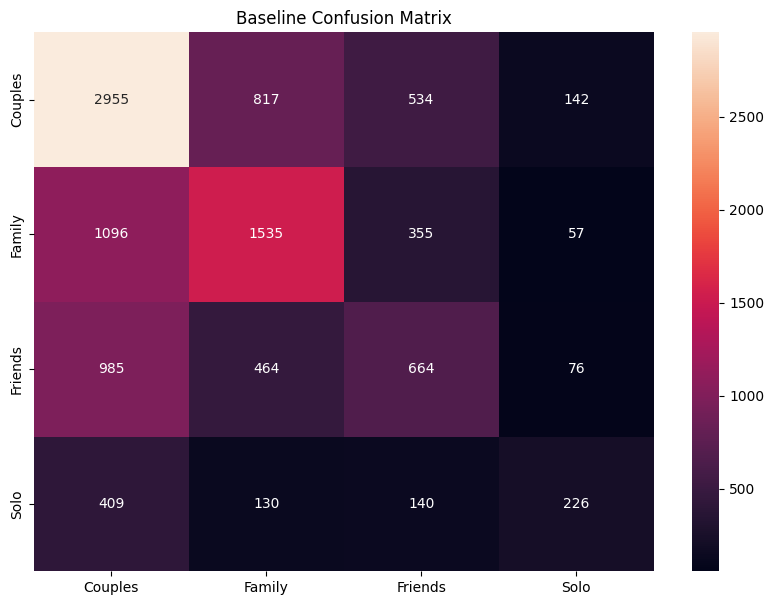

In [7]:
from sklearn.ensemble import RandomForestClassifier

print("\nTraining baseline Random Forest model...")
baseline_clf = RandomForestClassifier(random_state=42)
baseline_clf.fit(X_train_clf, y_train_clf)

# Evaluate
y_pred_baseline = baseline_clf.predict(X_test_clf)

print("\nBaseline Model Performance:")
print(classification_report(
    y_test_clf, 
    y_pred_baseline, 
    target_names=class_names,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_baseline)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Baseline Confusion Matrix')
plt.show()

### **2.2 Handling Class Imbalance**


Training models with class imbalance handling...


d:\Projects\Guvi_Project4\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [01:43:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Balanced Random Forest ===
Balanced Accuracy: 0.43738581750802086
              precision    recall  f1-score   support

     Couples       0.58      0.47      0.52      4448
      Family       0.52      0.50      0.51      3043
     Friends       0.34      0.38      0.36      2189
        Solo       0.22      0.40      0.28       905

    accuracy                           0.45     10585
   macro avg       0.42      0.44      0.42     10585
weighted avg       0.48      0.45      0.46     10585



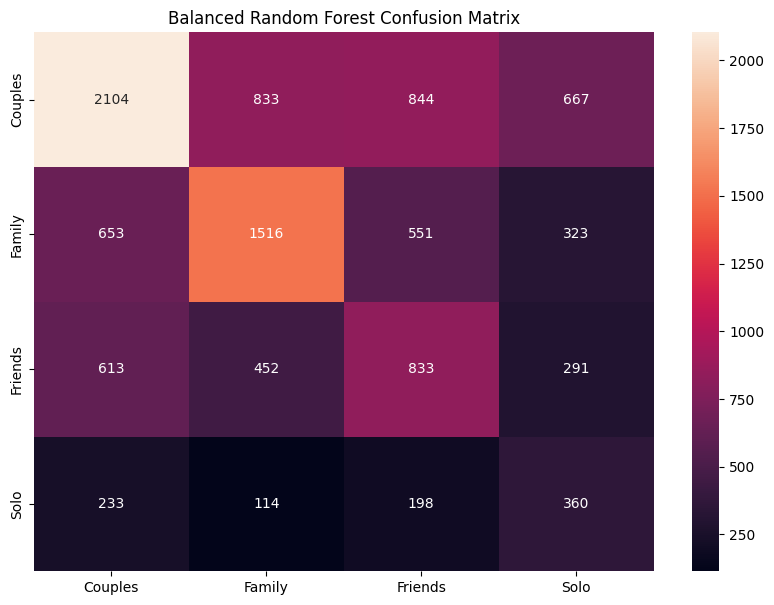


=== Weighted XGBoost ===
Balanced Accuracy: 0.40101188798520665
              precision    recall  f1-score   support

     Couples       0.52      0.84      0.64      4448
      Family       0.58      0.45      0.51      3043
     Friends       0.51      0.20      0.29      2189
        Solo       0.78      0.12      0.21       905

    accuracy                           0.53     10585
   macro avg       0.59      0.40      0.41     10585
weighted avg       0.55      0.53      0.49     10585



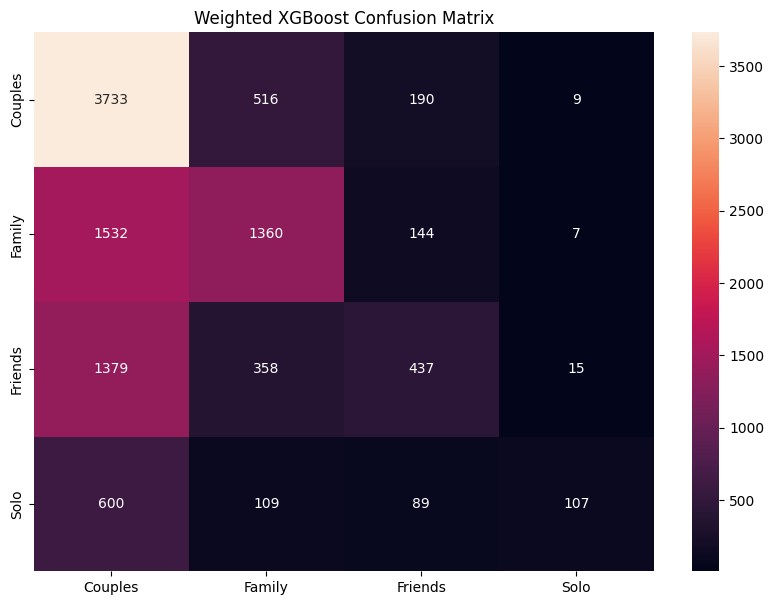

In [8]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

print("\nTraining models with class imbalance handling...")

# Option 1: Balanced Random Forest
brf = BalancedRandomForestClassifier(
    random_state=42,
    n_estimators=200,
    sampling_strategy='all'
)
brf.fit(X_train_clf, y_train_clf)

# Option 2: Class-weighted XGBoost
from xgboost import XGBClassifier

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_clf), y=y_train_clf)
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    scale_pos_weight=class_weights,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train_clf, y_train_clf)

# Evaluate both models
models = {
    "Balanced Random Forest": brf,
    "Weighted XGBoost": xgb
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test_clf)
    
    print("Balanced Accuracy:", balanced_accuracy_score(y_test_clf, y_pred))
    print(classification_report(
        y_test_clf, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    ))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_clf, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{name} Confusion Matrix')
    plt.show()


## **3. Model Optimization**

### **3.1 Feature Importance Analysis**


Analyzing feature importance...


<Figure size 1200x800 with 0 Axes>

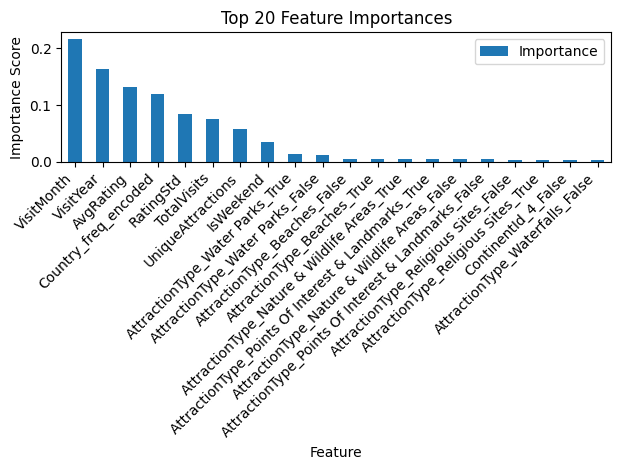

In [9]:
print("\nAnalyzing feature importance...")
# Get feature importances from the best model
importances = brf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_clf.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
feature_importance.head(20).plot.bar(x='Feature', y='Importance')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **3.2 Hyperparameter Tuning (Optional)**

In [10]:
# Uncomment to run hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='balanced_accuracy'
)
grid_search.fit(X_train_clf, y_train_clf)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


## **4. Final Model & Saving Pipeline**

### **4.1 Train Final Model**

In [11]:
print("\nTraining final model...")
final_model = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    sampling_strategy='all'
)
final_model.fit(X_train_clf, y_train_clf)

# Final evaluation
y_pred_final = final_model.predict(X_test_clf)

print("\nFinal Model Performance:")
print("Balanced Accuracy:", balanced_accuracy_score(y_test_clf, y_pred_final))
print(classification_report(
    y_test_clf, 
    y_pred_final, 
    target_names=class_names,
    zero_division=0
))



Training final model...

Final Model Performance:
Balanced Accuracy: 0.38324412872973646
              precision    recall  f1-score   support

     Couples       0.53      0.46      0.49      4448
      Family       0.52      0.40      0.45      3043
     Friends       0.32      0.26      0.29      2189
        Solo       0.14      0.42      0.21       905

    accuracy                           0.40     10585
   macro avg       0.38      0.38      0.36     10585
weighted avg       0.45      0.40      0.41     10585



### **4.2 Save Model Pipeline**

In [12]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('tourism_models/visit_prediction', exist_ok=True)

# Save components
print("\nSaving model pipeline components...")
joblib.dump(final_model, 'tourism_models/visit_prediction/model.pkl')
joblib.dump(le, 'tourism_models/visit_prediction/label_encoder.pkl')

# Save feature names
feature_names = X_clf.columns.tolist()
joblib.dump(feature_names, 'tourism_models/visit_prediction/feature_names.pkl')

# Save feature template
feature_template = {name: 0 for name in feature_names}
joblib.dump(feature_template, 'tourism_models/visit_prediction/feature_template.pkl')

print("\nAll components saved successfully:")
print("- Model: tourism_models/visit_prediction/model.pkl")
print("- Label encoder: tourism_models/visit_prediction/label_encoder.pkl")
print("- Feature names: tourism_models/visit_prediction/feature_names.pkl")
print("- Feature template: tourism_models/visit_prediction/feature_template.pkl")


Saving model pipeline components...

All components saved successfully:
- Model: tourism_models/visit_prediction/model.pkl
- Label encoder: tourism_models/visit_prediction/label_encoder.pkl
- Feature names: tourism_models/visit_prediction/feature_names.pkl
- Feature template: tourism_models/visit_prediction/feature_template.pkl


## **5. Prediction Verification**

In [14]:
def predict_visit_mode(input_features):
    """
    Predict visit mode from input features
    Args:
        input_features: dict with available features (can be partial)
    Returns:
        Predicted visit mode (string)
    """
    # Load all required components
    model = joblib.load('tourism_models/visit_prediction/model.pkl')
    le = joblib.load('tourism_models/visit_prediction/label_encoder.pkl')
    feature_names = joblib.load('tourism_models/visit_prediction/feature_names.pkl')
    template = joblib.load('tourism_models/visit_prediction/feature_template.pkl')
    
    # Update template with provided features
    for key in input_features:
        if key in template:
            template[key] = input_features[key]
        else:
            print(f"Warning: Feature '{key}' not in original training data")
    
    # Create DataFrame with correct column order
    input_df = pd.DataFrame([template], columns=feature_names)
    
    # Predict and decode
    prediction = model.predict(input_df)
    return le.inverse_transform(prediction)[0]

# Test prediction
print("\nTesting prediction function...")
test_sample = {
    'AvgRating': 4.5,
    'TotalVisits': 10,
    'RatingStd': 0.5,
    'UniqueAttractions': 5,
    'VisitYear': 2023,
    'VisitMonth': 6,
    'AttractionType_Museum': 1,
    'ContinentId_Europe': 1
}

try:
    predicted_mode = predict_visit_mode(test_sample)
    print(f"Predicted Visit Mode: {predicted_mode}")
except Exception as e:
    print(f"Prediction failed: {str(e)}")


Testing prediction function...
Predicted Visit Mode: Friends
